### Japanese Text Analysis with NHK (Japan Broadcasting Corporation) Show Information
In this notebook, I am analyzing NHK’s show information using Natural Language Processing (NLP) and topic modeling techniques including NMF, LSA, and LDA.  K-Means was used for clustering the shows into different genres.  

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [3]:
import MeCab # text segmentation library for Japanese texts
from glob import glob

In [16]:
df = pd.read_csv("https://raw.githubusercontent.com/mhunter13/NLP_final_project/main/nhk_0626_0703_0710.csv")

In [17]:
df.shape

(9695, 22)

In [18]:
df.head(1)

,id,event_id,start_time,end_time,title,subtitle,content,act,genres,area.id,...,service.name,service.logo_s.url,service.logo_s.width,service.logo_s.height,service.logo_m.url,service.logo_m.width,service.logo_m.height,service.logo_l.url,service.logo_l.width,service.logo_l.height
0,2022062633674,33674,2022-06-26T04:13:00+09:00,2022-06-26T04:15:00+09:00,インターミッション,NaN,NaN,NaN,['0815'],130,...,ＮＨＫ総合１,//www.nhk.or.jp/common/img/media/gtv-100x50.png,100,50,//www.nhk.or.jp/common/img/media/gtv-200x100.png,200,100,//www.nhk.or.jp/common/img/media/gtv-200x200.png,200,200


In [20]:
## remove duplicates
print(df.shape)
df = df.drop_duplicates("event_id").reset_index(drop=True)
print(df.shape)

(7554, 22)
(7554, 22)


In [21]:
df['genre_code'] = df['genres'].str[2:4] # new "genre1" column with just one genre code

In [22]:
df['genre_code'].unique()

array(['08', '11', '04', '00', '03', '02', '05', '01', '10', '09', '07',
       '15', '06', ''], dtype=object)

In [23]:
df['title'].loc[df['genre_code'] == '15'].head(10) # checking genre "15" which is not listed on NHK

176                  ラジオ深夜便　▽夜明けのオペラ
234                   ラジオ深夜便　▽ないとガイド
236     ラジオ深夜便　▽日本列島くらしのたより　▽ようこそ宇宙へ
238                   ラジオ深夜便　▽ラジオ文芸館
240              ラジオ深夜便　▽ロマンチックコンサート
242              ラジオ深夜便　▽にっぽんの歌こころの歌
244                     ラジオ深夜便　▽絶望名言
626     ラジオ深夜便　▽深夜便かがく部　▽岸本葉子の暮らしと俳句
628    ラジオ深夜便　▽日本列島くらしのたより　▽おとなの教養講座
630                ラジオ深夜便　▽深夜便アーカイブス
Name: title, dtype: object

In [24]:
label_dict = {'00':'ニュース/報道','01':'スポーツ','02':'情報/ワイドショー','03':'ドラマ','04':'音楽','05':'バラエティー','06':'映画','07':'アニメ','08':'ドキュメンタリー','09':'劇場・公演','10':'趣味・教育','11':'福祉','15':'その他'} 
# create label dict

In [25]:
df['label'] = df.genre_code.replace(label_dict) # creating label column with category names
df['genre_code'] = pd.to_numeric(df['genre_code'])
df.dropna(subset=['genre_code'], inplace=True)
df['genre_code'] = df['genre_code'].astype(int)
df.loc[df['genre_code'] == 15, 'genre_code'] = 12
df['info'] = df['title'] + df['subtitle'].fillna('') # + df['content'].fillna('') #combining title, subtitle, and content - subtitle and content have NaN values
df.head(2)

,id,event_id,start_time,end_time,title,subtitle,content,act,genres,area.id,...,service.logo_s.height,service.logo_m.url,service.logo_m.width,service.logo_m.height,service.logo_l.url,service.logo_l.width,service.logo_l.height,genre_code,label,info
0,2022062633674,33674,2022-06-26T04:13:00+09:00,2022-06-26T04:15:00+09:00,インターミッション,NaN,NaN,NaN,['0815'],130,...,50,//www.nhk.or.jp/common/img/media/gtv-200x100.png,200,100,//www.nhk.or.jp/common/img/media/gtv-200x200.png,200,200,8,ドキュメンタリー,インターミッション
1,2022062633676,33676,2022-06-26T04:15:00+09:00,2022-06-26T04:20:00+09:00,５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」,２０２１年度に放送したＥテレ「みんなの手話」から１つのキーフレーズをピックアップ。「祖父と祖...,２０２１年度に放送したＥテレ「みんなの手話」から１つのキーフレーズをピックアップ。「祖父と祖...,【出演】三宅健，森田明，那須善子，那須映里，寺澤英弥，【声】黒柳徹子,['1104'],130,...,50,//www.nhk.or.jp/common/img/media/gtv-200x100.png,200,100,//www.nhk.or.jp/common/img/media/gtv-200x200.png,200,200,11,福祉,５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」２０２１年度に放送したＥテレ「...


In [26]:
df = df[['start_time', 'title', 'info', 'genre_code', 'label']]
df.head()

,start_time,title,info,genre_code,label
0,2022-06-26T04:13:00+09:00,インターミッション,インターミッション,8,ドキュメンタリー
1,2022-06-26T04:15:00+09:00,５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」,５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」２０２１年度に放送したＥテレ「...,11,福祉
2,2022-06-26T04:20:00+09:00,名曲アルバム「ソルヴェイグの歌」グリーグ作曲,名曲アルバム「ソルヴェイグの歌」グリーグ作曲「ソルヴェイグの歌」（ソプラノ）天羽明惠，（ピア...,4,音楽
3,2022-06-26T04:25:00+09:00,みんなのうた「くじらのあくび」,みんなのうた「くじらのあくび」「くじらのあくび」うた：ザ・ジェイド,4,音楽
4,2022-06-26T04:30:00+09:00,イッピン・選「色彩ゆたかに あざやかに」,イッピン・選「色彩ゆたかに あざやかに」「西の西陣・東の桐生」と並び称された織物の産地、群馬...,8,ドキュメンタリー


In [27]:
df.groupby(['genre_code', 'label'], as_index=False)['title'].count()

,genre_code,label,title
0,0,ニュース/報道,2236
1,1,スポーツ,296
2,2,情報/ワイドショー,442
3,3,ドラマ,245
4,4,音楽,704
5,5,バラエティー,226
6,6,映画,14
7,7,アニメ,153
8,8,ドキュメンタリー,1007
9,9,劇場・公演,24


### Text Pre-processing

In [28]:
!pip install neologdn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 57 kB 2.6 MB/s 
  Created wheel for neologdn: filename=neologdn-0.5.1-cp37-cp37m-linux_x86_64.whl size=172962 sha256=06668816dee89f886d725ca5d4fe73191be47744a7be5efaea4a95687c2b4c76
  Stored in directory: /root/.cache/pip/wheels/19/15/5c/55b33d02e16129ef81313e4c86e473d6dd1cecf7317a525a9b
Successfully built neologdn


In [29]:
import neologdn # 全角、半角の統一、Unicode正規化, Japanese text normalizer

In [ ]:
# testing neologdn
# text = df['all_content'].iloc[1]
# print(text)
# neologdn.normalize(text)

In [30]:
# Using MeCab to tokenize then get 名詞(nouns)
def nouns(article):
    text = neologdn.normalize(article) #全角、半角の統一,Unicode正規化
    tmp = re.sub(r'(\d)([,.])(\d+)', r'\1\3', text) #removing decimal numbers
    text = re.sub(r'\d+', '0', tmp) #replacing numbers with 0
    text = re.sub('[a-z]', '', text)
    text = re.sub('[A-Z]', '', text)

    word_list = ""

    path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
    m=MeCab.Tagger()
    m1=m.parse (text)
    for row in m1.split("\n"):
        word =row.split("\t")[0]#1st element: 形態素
        if word == "EOS":
            break
        else:
            pos = row.split("\t")[1]#2nd element: 品詞
            slice = pos[:2]
            if slice == "名詞":
                word_list = word_list +" "+ word

    return word_list

In [31]:
df['words'] = df['info'].apply(nouns)

In [32]:
df['words'].head(2)

0                                           インター ミッション
1     0 分 みんな 手話 祖父 祖母 両親 きょう だい 0 人 ん 0 年度 放送 テレ み...
Name: words, dtype: object

In [33]:
docs = df['words'] 

In [34]:
sum([len(d.split(' ')) for d in docs]) # count

141017

### Vectorize (using TfidVectorizer)




In [35]:
stop_words = ['さん','たち','あなた','みんな','こと','出演','番組','シリーズ','ゲスト','どこ','マイ','ため','さまざま','ほか','コーナー','お伝え','今回','ラジオ','テレビ','放送','テーマ','場合']

In [36]:
tfidf = TfidfVectorizer(stop_words = stop_words, smooth_idf=False) # includes length 1 words (token_pattern=u'(?u)\\b\\w+\\b')
tfid_vec = tfidf.fit_transform(docs)

values = tfid_vec.toarray()
vocabs = tfidf.get_feature_names()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
tfid_vec.shape

(7453, 9859)

In [38]:
df_new = pd.DataFrame(values, columns = vocabs)
df_new.head(2)

,00,〇〇,ぁれ,あい,あいさつ,あいだ,あか,あかね,あかり,あきらか,...,黒砂糖,黒谷,黒部,黒部五郎岳,黒部川,鼓動,齋藤,齋貞,龍男,龍郎
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### NMF

In [39]:
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

In [40]:
n_topics = 13
nmf = NMF(n_components=n_topics)

In [41]:
genres_nmf = nmf.fit_transform(tfid_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [42]:
nmf.components_.shape

(13, 9859)

In [43]:
nmf_topic = pd.DataFrame(nmf.components_.round(3), columns = vocabs)

In [44]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [45]:
display_topics(nmf, tfidf.get_feature_names_out(), 6)


Topic  0
ニュース, 日本, きょう, 関東甲信越, 中国, スペイン

Topic  1
天気, 予報, 交通, 情報, 全国, 海上

Topic  2
気象, 情報, 通報, 交通, 関東甲信越, カラフル

Topic  3
英語, 基礎, レベル, 中学生, 中高生, 前年度

Topic  4
選挙, 選出, 議員, 参議院, 政見, 一部

Topic  5
国内外, 内容, 変更, スポーツ, 中継, 時間

Topic  6
教授, 英会話, 講師, 大学, ジェニー, スキッドモア

Topic  7
うた, 踊り子, 地帯, 安全, しな, ポップ

Topic  8
音楽, カフェ, ミュージック, 話題, 世界, リクエスト

Topic  9
講師, 非常勤, 中国語, ハングル, 講座, キム

Topic  10
様々, 届け, 時間, 情報, 全国, 解説

Topic  11
イングリッシュ, エンジョイ, 関根, 麻里, シンプル, 司会

Topic  12
体操, 多胡, 歳児, 対象, エンターテインメント, 教育


In [47]:
H = pd.DataFrame(genres_nmf.round(5), index=[df['title']], columns = ['0:ニュース', '1:全国ニュース', '2:関東ニュース', '3:基礎英語', '4:政治', '5:スポーツ', '6:英会話', '7:音楽','8:趣味/旅行','9:アジア言語','10:情報','11:英語レッスン','12:こども'])
H

,0:ニュース,1:全国ニュース,2:関東ニュース,3:基礎英語,4:政治,5:スポーツ,6:英会話,7:音楽,8:趣味/旅行,9:アジア言語,10:情報,11:英語レッスン,12:こども
title,,,,,,,,,,,,,
インターミッション,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00001,0.00001,0.00002,0.00000,0.00003
５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」,0.00138,0.0,0.00000,0.00036,0.00503,0.00080,0.00000,0.00062,0.00037,0.00059,0.00237,0.00161,0.00352
名曲アルバム「ソルヴェイグの歌」グリーグ作曲,0.00000,0.0,0.00000,0.00002,0.00005,0.00000,0.00001,0.00009,0.00135,0.00010,0.00023,0.00002,0.00017
みんなのうた「くじらのあくび」,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.10225,0.00000,0.00000,0.00000,0.00000,0.00000
イッピン・選「色彩ゆたかに あざやかに」,0.00003,0.0,0.00000,0.00000,0.00087,0.00000,0.00000,0.00007,0.00019,0.00015,0.00102,0.00003,0.00338
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ヨーロッパ トラムの旅「チェコ プラハ」,0.00000,0.0,0.00000,0.00008,0.00000,0.00943,0.00000,0.00002,0.00000,0.00013,0.02537,0.00000,0.00042
ヨーロッパ トラムの旅「セルビア ベオグラード」,0.00000,0.0,0.00000,0.00007,0.00000,0.00863,0.00000,0.00001,0.00000,0.00005,0.02304,0.00000,0.00025
映像詩「祈りの桜 奈良県吉野山」,0.00016,0.0,0.00000,0.00017,0.00015,0.00000,0.00000,0.00012,0.00087,0.00023,0.00130,0.00001,0.00314


In [ ]:
# def get_top_terms(topic, n_terms, nmf=nmf, terms=vocabs):
#     # get the topic components (i.e., term weights)
#     components=nmf.components_[topic,:]
#     # get term indices, sorted (descending) by topic weights
#     top_term_indices =components.argsort()[-n_terms:]
#     # use the `terms` array to get the actual top terms
#     top_terms =np.array(terms)[top_term_indices]
#     return top_terms.tolist()

In [ ]:
# # define the topics
# topics = ['-'.join(get_top_terms(i,5)) for i in range(10)]
# topics

### LSA

In [48]:
lsa = TruncatedSVD(13)
genres_lsa = lsa.fit_transform(tfid_vec)

In [49]:
lsa.explained_variance_ratio_

array([0.06090096, 0.03015387, 0.02570513, 0.01575778, 0.01395884,
       0.01263303, 0.01200891, 0.00983224, 0.00908504, 0.00853357,
       0.00824703, 0.00820532, 0.00643791])

In [50]:
lsa_topic = pd.DataFrame(lsa.components_.round(3), columns = vocabs)

In [51]:
display_topics(lsa, tfidf.get_feature_names_out(), 6)


Topic  0
ニュース, 情報, 気象, 予報, 天気, 交通

Topic  1
天気, 予報, 情報, 交通, 気象, 全国

Topic  2
気象, 情報, 時間, 国内外, スポーツ, 内容

Topic  3
英語, 基礎, レベル, 中学生, 中高生, 講師

Topic  4
選挙, 選出, 議員, 参議院, 政見, 一部

Topic  5
気象, 情報, 関東甲信越, 通報, 講師, 関東

Topic  6
講師, 教授, 英会話, 大学, ジェニー, ソレイシィ

Topic  7
うた, 踊り子, 地帯, 安全, しな, ポップ

Topic  8
音楽, 届け, 様々, カフェ, 時間, ミュージック

Topic  9
講師, 非常勤, ハングル, 中国語, キム, ウナ

Topic  10
様々, 届け, 時間, 情報, 全国, 首都

Topic  11
イングリッシュ, エンジョイ, 関根, 麻里, シンプル, 司会

Topic  12
体操, 多胡, 歳児, 対象, エンターテインメント, 教育


In [52]:
V = pd.DataFrame(genres_lsa.round(5), index=[df['title']], columns = ['0:ニュース', '1:全国ニュース', '2:スポーツ', '3:基礎英語', '4:政治', '5:関東ニュース', '6:英会話', '7:音楽','8:趣味・音楽','9:アジア言語','10:情報','11:英会話','12:こども'])
V

,0:ニュース,1:全国ニュース,2:スポーツ,3:基礎英語,4:政治,5:関東ニュース,6:英会話,7:音楽,8:趣味・音楽,9:アジア言語,10:情報,11:英会話,12:こども
title,,,,,,,,,,,,,
インターミッション,0.00000,0.00000,0.00001,0.00001,0.00000,0.00001,0.00002,0.00003,0.00001,0.00002,0.00005,0.00001,0.00012
５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」,0.00819,-0.00524,0.00229,0.00163,0.01632,-0.00376,0.00154,0.00141,0.00226,0.00377,0.01158,0.00309,0.02194
名曲アルバム「ソルヴェイグの歌」グリーグ作曲,0.00001,-0.00000,0.00003,0.00017,0.00020,-0.00009,0.00030,0.00032,0.00422,0.00015,0.00037,-0.00003,0.00166
みんなのうた「くじらのあくび」,0.00011,0.00113,-0.00094,0.00080,0.00020,-0.00256,0.00205,0.29852,-0.01423,-0.00132,0.00107,-0.00040,-0.00294
イッピン・選「色彩ゆたかに あざやかに」,0.00041,0.00028,0.00043,0.00026,0.00278,0.00104,0.00016,0.00062,0.00131,0.00097,0.00425,-0.00012,0.00926
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ヨーロッパ トラムの旅「チェコ プラハ」,0.01058,0.00683,0.03373,0.00147,0.00041,-0.05099,0.00464,-0.00010,0.00810,0.00710,0.06070,-0.00384,-0.00573
ヨーロッパ トラムの旅「セルビア ベオグラード」,0.00966,0.00625,0.03080,0.00128,0.00036,-0.04647,0.00413,-0.00010,0.00725,0.00640,0.05493,-0.00351,-0.00580
映像詩「祈りの桜 奈良県吉野山」,0.00096,-0.00036,-0.00045,0.00090,0.00052,-0.00118,0.00056,0.00063,0.00353,0.00103,0.00625,-0.00056,0.01003


### LDA

In [53]:
! pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
from gensim import corpora, models, matutils
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [55]:
corpus = matutils.Sparse2Corpus(tfid_vec.transpose())
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=14, id2word=id2word, passes=10)

2022-07-10 02:25:34,923 : INFO : using symmetric alpha at 0.07142857142857142
2022-07-10 02:25:34,929 : INFO : using symmetric eta at 0.07142857142857142
2022-07-10 02:25:34,934 : INFO : using serial LDA version on this node
2022-07-10 02:25:34,963 : INFO : running online (multi-pass) LDA training, 14 topics, 10 passes over the supplied corpus of 7453 documents, updating model once every 2000 documents, evaluating perplexity every 7453 documents, iterating 50x with a convergence threshold of 0.001000
2022-07-10 02:25:34,978 : INFO : PROGRESS: pass 0, at document #2000/7453
2022-07-10 02:25:35,562 : INFO : merging changes from 2000 documents into a model of 7453 documents
2022-07-10 02:25:35,595 : INFO : topic #13 (0.071): 0.007*"ミュージック" + 0.007*"南波" + 0.007*"志帆" + 0.006*"ライン" + 0.006*"情報" + 0.006*"ニュース" + 0.006*"うた" + 0.005*"首都" + 0.004*"日本" + 0.004*"気象"
2022-07-10 02:25:35,601 : INFO : topic #1 (0.071): 0.021*"天気" + 0.017*"予報" + 0.015*"ニュース" + 0.015*"交通" + 0.014*"情報" + 0.011*"全国" + 0.

In [56]:
lda.print_topics();

2022-07-10 02:26:09,295 : INFO : topic #0 (0.071): 0.017*"ラボ" + 0.015*"名曲" + 0.010*"スケッチ" + 0.009*"深夜" + 0.008*"レシピ" + 0.007*"空白" + 0.006*"ダイジェスト" + 0.005*"高校" + 0.005*"関西" + 0.005*"芸術"
2022-07-10 02:26:09,298 : INFO : topic #1 (0.071): 0.065*"天気" + 0.062*"予報" + 0.044*"交通" + 0.036*"ニュース" + 0.034*"情報" + 0.018*"全国" + 0.008*"世界" + 0.007*"極意" + 0.007*"ポール" + 0.007*"ハート"
2022-07-10 02:26:09,299 : INFO : topic #2 (0.071): 0.011*"にっぽん" + 0.010*"イタリア" + 0.009*"北海道" + 0.009*"こころ" + 0.008*"英語" + 0.008*"野村" + 0.007*"世界" + 0.006*"最新" + 0.006*"国際" + 0.006*"きょう"
2022-07-10 02:26:09,301 : INFO : topic #3 (0.071): 0.028*"英語" + 0.027*"レベル" + 0.027*"中学生" + 0.024*"基礎" + 0.015*"ハングル" + 0.013*"関根" + 0.012*"麻里" + 0.012*"エンジョイ" + 0.012*"イングリッシュ" + 0.012*"シンプル"
2022-07-10 02:26:09,303 : INFO : topic #4 (0.071): 0.073*"気象" + 0.071*"情報" + 0.065*"ニュース" + 0.037*"時間" + 0.030*"スポーツ" + 0.028*"国内外" + 0.027*"内容" + 0.026*"中継" + 0.026*"変更" + 0.016*"様々"
2022-07-10 02:26:09,305 : INFO : topic #5 (0.071): 0.033*"音楽" + 0.01

"kids" and "politics" categories are not as distinct as LSA/NMF

### Top 100 words
Show top 100 words using Word Cloud.
Show the same Word Cloud in English. Use Google translator for translation.

In [57]:
count_vec = CountVectorizer(stop_words = stop_words)
CV = count_vec.fit_transform(docs)

cv_values = CV.toarray()
cv_vocabs = count_vec.get_feature_names()

dtm = pd.DataFrame(cv_values, columns=cv_vocabs)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# count_vec.vocabulary_ #words and column position

In [58]:
# 100 top words
sum = dtm.sum().sort_values(ascending = False)
top100 = sum[:100]

In [59]:
import plotly.express as px

In [60]:
fig = px.bar(top100)
fig.show()

In [61]:
df_sum = sum.to_frame().reset_index()
df_sum.columns = ['word', 'count']
data = df_sum.set_index('word').to_dict()['count'] # for word cloud

In [62]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 5.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=273a8cc23abc3c1137e440bd8f75ccc79905de2cee656cabbc02e8245f4c70e6
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [63]:
import japanize_matplotlib

In [64]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 61 not upgraded.
Need to get 8,251 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-gothic all 00303-18ubuntu1 [3,526 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-ipafont-mincho all 00303-18ubuntu1 [4,725 kB]
Fetched 8,251 kB in 1s (16.1 MB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 156303 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-18ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-18ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [65]:
from wordcloud import WordCloud
fpath = '/usr/share/fonts/truetype/fonts-japanese-gothic.ttf'  # 日本語フォント

In [66]:
wc = WordCloud(width=720, height=720, background_color='white', font_path=fpath, max_words=100).generate_from_frequencies(data)

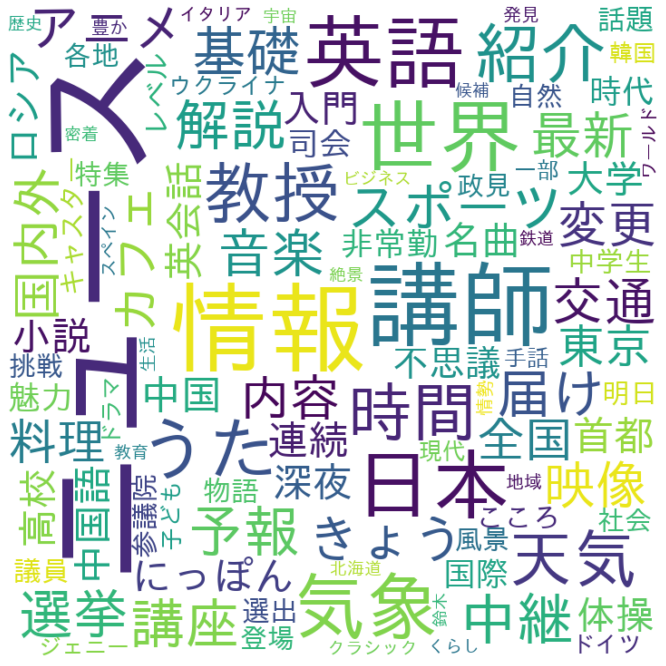

In [67]:
plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig("word_cloud.png")
plt.show()

In [ ]:
# English translation using googletrans

In [68]:
!pip install googletrans==4.0.0-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 1.3 MB 9.3 MB/s 
     |████████████████████████████████| 65 kB 1.9 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17416 sha256=5a6dd2ea3b31a1f7c4ceca5d493d75775f737deb0a2d3cd48c05d2446bea355d
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


In [69]:
from googletrans import Translator

In [70]:
def to_EN_translation(word):
  translator = Translator()
  translation = translator.translate(word, dest='en')
  return translation.text

In [71]:
df_100 = df_sum[:100] # translate 100 words only - takes too long otherwise
df_100['EN'] = df_100['word'].apply(to_EN_translation)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
df_100.head(50)

,word,count,EN
0,ニュース,2153,news
1,情報,970,information
2,講師,875,Teacher
3,世界,647,world
4,英語,633,English
5,日本,594,Japan
6,気象,522,weather
7,うた,467,Squirming
8,教授,438,professor
9,紹介,409,Introduction


In [73]:
dataEN = df_100.set_index('EN').to_dict()['count'] # for word cloud
wcEN = WordCloud(width=720, height=720, background_color='white', font_path=fpath, max_words=100).generate_from_frequencies(dataEN)

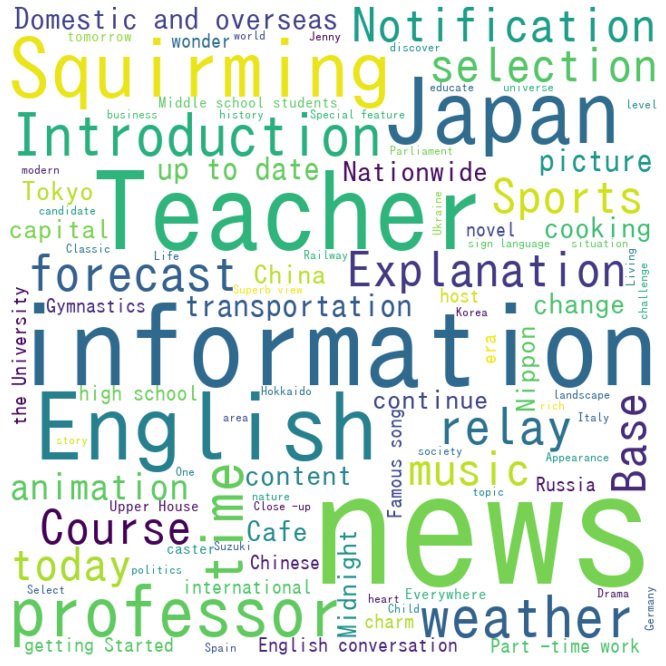

In [74]:
plt.figure(figsize=(12,12))
plt.imshow(wcEN, interpolation='bilinear')
plt.axis('off')
plt.savefig("word_cloud_EN.png")
plt.show()

In [ ]:
# some of the words are not correctly translated by google translator

### Kmeans Clustering

In [75]:
from sklearn.cluster import KMeans

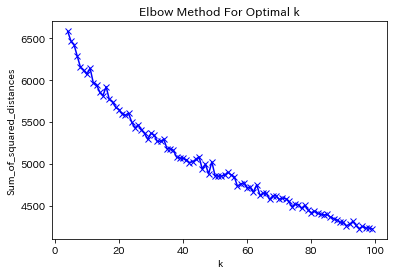

In [116]:
Sum_of_squared_distances = []
K = range(4,100)
for k in K:
   km = KMeans(n_clusters=k)
   km = km.fit(tfid_vec)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [77]:
km_12 = KMeans(n_clusters=12,verbose=1, random_state=42)#init='k-means++', max_iter=200, n_init=10)
km_12.fit(tfid_vec)
labels=km_12.labels_

Initialization complete
Iteration 0, inertia 11431.592660408965
Iteration 1, inertia 6194.785015386026
Iteration 2, inertia 6118.956964657922
Iteration 3, inertia 6092.337419868438
Iteration 4, inertia 6074.24075353581
Iteration 5, inertia 6053.07454901505
Iteration 6, inertia 6032.490851962439
Iteration 7, inertia 6030.477026899471
Iteration 8, inertia 6029.976525088337
Iteration 9, inertia 6029.910712200314
Iteration 10, inertia 6029.515369082337
Iteration 11, inertia 6029.508618347765
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 11913.467279854689
Iteration 1, inertia 6516.375877688865
Iteration 2, inertia 6414.418728505792
Iteration 3, inertia 6353.223526124975
Iteration 4, inertia 6299.782564086565
Iteration 5, inertia 6275.94929911942
Iteration 6, inertia 6267.575139156073
Iteration 7, inertia 6264.7750468443855
Iteration 8, inertia 6262.434372803606
Iteration 9, inertia 6255.895710351399
Iteration 10, inertia 6241.380517380886
Itera

In [78]:
df['cluster'] = pd.DataFrame(list(labels), columns=['cluster'])
df.head(2)

,start_time,title,info,genre_code,label,words,cluster
0,2022-06-26T04:13:00+09:00,インターミッション,インターミッション,8,ドキュメンタリー,インター ミッション,0.0
1,2022-06-26T04:15:00+09:00,５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」,５分でみんなの手話「祖父と祖母と両親ときょうだいが４人なんだ」２０２１年度に放送したＥテレ「...,11,福祉,0 分 みんな 手話 祖父 祖母 両親 きょう だい 0 人 ん 0 年度 放送 テレ み...,0.0


In [79]:
sum_cluster = df.groupby(['cluster'], as_index=False)['title'].count()
sum_cluster

,cluster,title
0,0.0,4615
1,1.0,327
2,2.0,117
3,3.0,125
4,4.0,552
5,5.0,175
6,6.0,472
7,7.0,115
8,8.0,328
9,9.0,131


In [80]:
fig = px.bar(sum_cluster, x='cluster', y='title', text_auto='.2s', width=600, height=400)
fig.update_layout(xaxis=dict(tickmode = 'linear', tick0=0, dtick=1))
fig.show()

In [81]:
result={'cluster':labels,'show':docs}
result=pd.DataFrame(result)


Cluster: 0


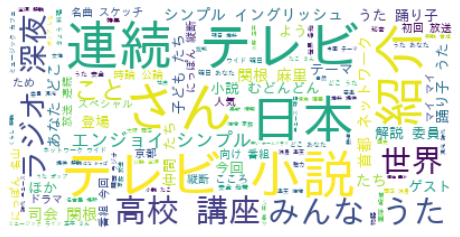

Cluster: 1


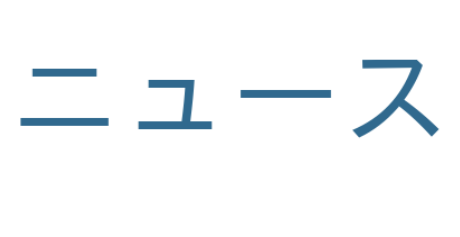

Cluster: 2


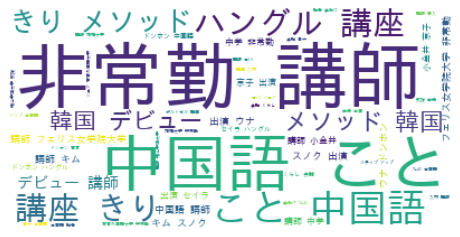

Cluster: 3


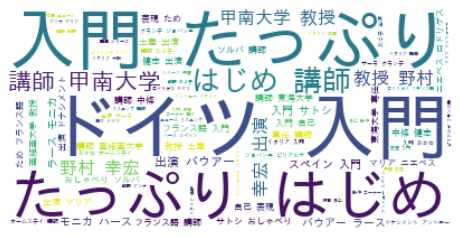

Cluster: 4


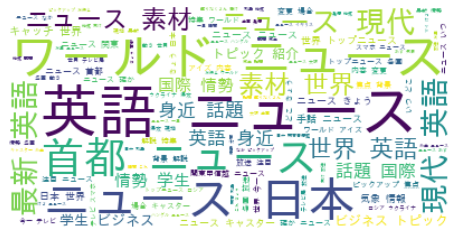

Cluster: 5


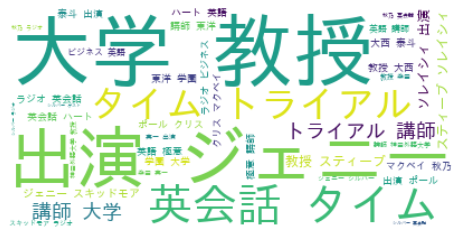

Cluster: 6


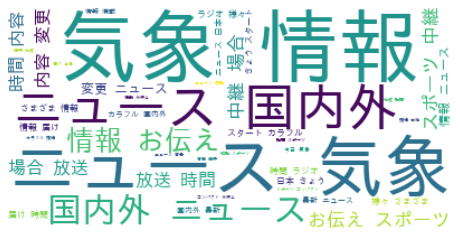

Cluster: 7


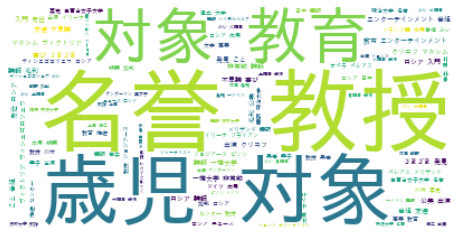

Cluster: 8


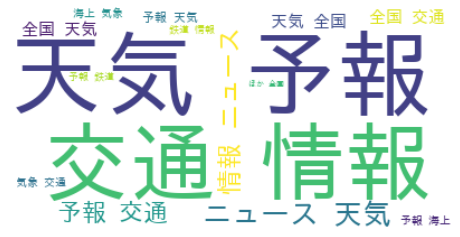

Cluster: 9


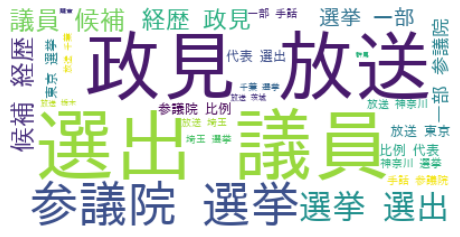

Cluster: 10


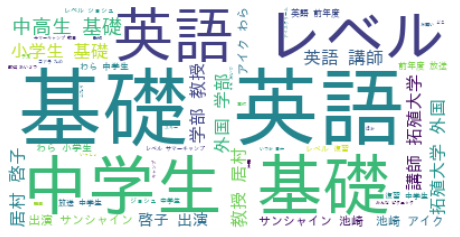

Cluster: 11


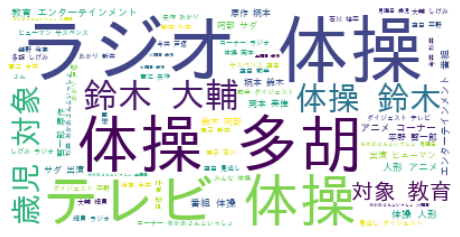

In [82]:
for k in range(12):
   s=result[result['cluster']==k]

   text=s['show'].str.cat(sep=' ')
   text=' '.join([word for word in text.split()])
   wc = WordCloud(background_color='white', font_path=fpath, max_words=100).generate(text)

   print('Cluster: {}'.format(k))
   plt.figure(figsize=(8,8))
   plt.imshow(wc, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [103]:
# listing 5 programs per cluster
for k in range(12):
   s=result[result['cluster']==k]
   print(s.show.sample(5)) # show random 5 rows

7854                           ら きょう ニュース きょう ニュース 野村 正 育
5742     ニュース 0 確か ニュース いつ どこ きょう 日本 世界 今一 歩 先 一 歩 テレビ...
7541     首都 圏 ネットワーク 首都 圏 ネットワーク ワイド !「 明日 あなた 0 分間 いま...
7914                                           ロシア 語 ニュース
431                                        ニュース ( 関東甲信越 )
Name: show, dtype: object
8021                                                気象 情報
8963                         ら 時間 ラジオ 様々 ( さまざま ) 情報 届け !
5420     ニュース +▽ 国内外 ニュース 気象 情報 お伝え スポーツ 中継 場合 放送 時間 内...
400      ニュース 日本 きょう スタート カラフル ! 国内外 最新 ニュース 届け ! 気 ニュ...
6162                         ら 時間 ラジオ 様々 ( さまざま ) 情報 届け !
Name: show, dtype: object
5539        参議院 選挙 区 選出 議員 候補 者 経歴 政見 放送 千葉 県 選挙 区 ( 一部 )
2249        参議院 選挙 区 選出 議員 候補 者 経歴 政見 放送 千葉 県 選挙 区 ( 一部 )
426      参議院 選挙 区 選出 議員 候補 者 経歴 政見 放送 東京 都 選挙 区 ( 一部 )...
5520                             参議院 比例 代表 選出 議員 選挙 政見 放送
4139     参議院 選挙 区 選出 議員 候補 者 経歴 政見 放送 茨城 県 選挙 区 ( 一部 )...
Name: show, dtype: object
7150     大西 泰斗 英会話 定番 レシピ ( 0 ) 英会話 必要 文法 レシピ 0 ! さま

In [ ]:
# # cosine_similarity
# cosine_matrix = cosine_similarity(dtm)
# cosine_matrix.shape

### T-SNE for visualization

In [83]:
# !pip install bhtsne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 2.9 MB/s 
  Created wheel for bhtsne: filename=bhtsne-0.1.9-cp37-cp37m-linux_x86_64.whl size=216042 sha256=7bf12770be41079171c27b2994394d59e4b7847857e6c060acdce58f80ee0233
  Stored in directory: /root/.cache/pip/wheels/e4/4c/71/26b7b0736d179d6bfe9d753629955515bf7ba7c1c8a8d98cb4
Successfully built bhtsne


In [142]:
# import bhtsne


In [143]:
from sklearn.manifold import TSNE

In [144]:
tfid_vec

<7453x9859 sparse matrix of type '<class 'numpy.float64'>'
	with 72172 stored elements in Compressed Sparse Row format>

In [145]:
k = 13
km = KMeans(n_clusters=k,verbose=1, random_state=42)#init='k-means++', max_iter=200, n_init=10)
km.fit(tfid_vec)
labels=km.labels_

Initialization complete
Iteration 0, inertia 11396.24198104495
Iteration 1, inertia 6186.736539268087
Iteration 2, inertia 6090.124853199781
Iteration 3, inertia 6038.373462599902
Iteration 4, inertia 5992.581457146773
Iteration 5, inertia 5987.771437382082
Iteration 6, inertia 5982.70940597322
Iteration 7, inertia 5980.186008354818
Iteration 8, inertia 5979.683279405157
Iteration 9, inertia 5979.621495683055
Iteration 10, inertia 5979.225084262125
Iteration 11, inertia 5979.218319747331
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 6550.955013206035
Iteration 1, inertia 6358.815401983018
Iteration 2, inertia 6209.170471244306
Iteration 3, inertia 6157.782112699567
Iteration 4, inertia 6152.928857367823
Iteration 5, inertia 6152.78078048194
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 6309.943382103655
Iteration 1, inertia 6152.223171440796
Iteration 2, inertia 6151.609435344952
Converged at ite

In [123]:
tfid_vec_reduced = TruncatedSVD(n_components=k, random_state=123).fit_transform(tfid_vec)

In [146]:
tfid_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(tfid_vec_reduced)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7453 samples in 0.014s...
[t-SNE] Computed neighbors for 7453 samples in 0.674s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7453
[t-SNE] Computed conditional probabilities for sample 2000 / 7453
[t-SNE] Computed conditional probabilities for sample 3000 / 7453
[t-SNE] Computed conditional probabilities for sample 4000 / 7453
[t-SNE] Computed conditional probabilities for sample 5000 / 7453
[t-SNE] Computed conditional probabilities for sample 6000 / 7453
[t-SNE] Computed conditional probabilities for sample 7000 / 7453
[t-SNE] Computed conditional probabilities for sample 7453 / 7453
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.803s
[t-SNE] Iteration 50: error = 80.3987274, gradient norm = 0.0292346 (50 iterations in 4.097s)
[t-SNE] Iteration 100: error = 66.5440979, gradient norm = 0.0071776 (50 iterations in 3.061s)
[t-SNE] Iteration 150: error = 63.1731873, gradient norm = 

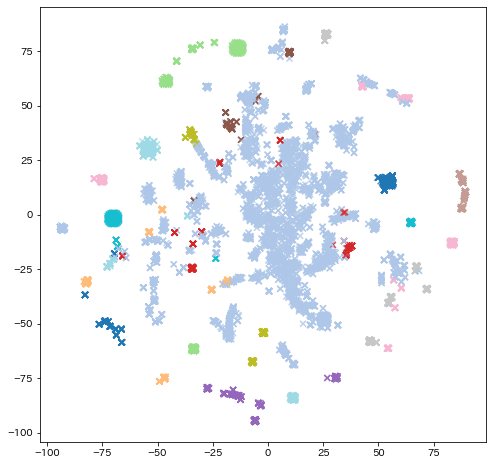

In [147]:
fig = plt.figure(figsize = (8, 8))
scatter = plt.scatter(tfid_embedded[:, 0], tfid_embedded[:, 1], marker = 'x', c = labels, cmap="tab20", alpha=0.8)
# plt.legend(handles=scatter.legend_elements()[0], 
#            title="clusters")
plt.show()